In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r'/content/Plantasia_Sep2019-Nov2020.csv')
df.index = pd.to_datetime(df['forecastPeriod'])
df = df.drop('locationId', axis=1)
df = df.drop('dataDate', axis=1)
df = df.drop('dataDateUT', axis=1)
df = df.drop('forecastPeriodUT', axis=1)
df = df.drop('forecastPeriod', axis=1)
df = df.drop('AO_total_consumption', axis=1)
le = LabelEncoder()
df['windDirection'] = le.fit_transform(df['windDirection'])
le1 = LabelEncoder()
df['visibility'] = le1.fit_transform(df['visibility'])
df = df.drop('windDirection', axis=1)
df = df.drop('windSpeed', axis=1)
df = df.drop('visibility', axis=1)
df = df.drop('feelsLike', axis=1)
df = df.drop('precipitationProbability', axis=1)
df = df.round({'AO_PV_generation': 1})

In [ ]:
df['seconds'] = df.index.map(pd.Timestamp.timestamp)

hour = 60*60
day = hour*24
year = 365.2425*day

df['Day sin'] = np.sin(df['seconds'] * (2* np.pi / day))
df['Day cos'] = np.cos(df['seconds'] * (2* np.pi / day))
df['Year sin'] = np.sin(df['seconds'] * (2* np.pi / year))
df['Year cos'] = np.cos(df['seconds'] * (2* np.pi / year))

df = df.drop('seconds', axis=1)
df

,temperature,weatherType,uvindex,AO_PV_generation,Day sin,Day cos,Year sin,Year cos
forecastPeriod,,,,,,,,
2019-09-01 00:00:00,14,7,0,0.0,-8.223106e-12,1.000000e+00,-0.862760,-0.505613
2019-09-01 03:00:00,12,2,0,0.0,7.071068e-01,7.071068e-01,-0.863845,-0.503757
2019-09-01 06:00:00,12,1,1,13.1,1.000000e+00,1.078645e-11,-0.864927,-0.501898
2019-09-01 09:00:00,14,3,3,32.1,7.071068e-01,-7.071068e-01,-0.866004,-0.500037
2019-09-01 12:00:00,17,3,5,33.2,1.334979e-11,-1.000000e+00,-0.867077,-0.498174
...,...,...,...,...,...,...,...,...
2020-11-30 09:00:00,9,8,1,1.8,7.071068e-01,-7.071068e-01,-0.508255,0.861207
2020-11-30 12:00:00,11,7,1,0.9,3.172823e-12,-1.000000e+00,-0.506402,0.862298
2020-11-30 15:00:00,11,7,1,0.0,-7.071068e-01,-7.071068e-01,-0.504546,0.863385


In [ ]:
def df_to_xy(df, windowSize):
  df_as_np = df.to_numpy()
  x = []
  y = []
  for i in range(len(df_as_np)-windowSize):
    row = [r for r in df_as_np[i:i+windowSize]]
    x.append(row)
    label = df_as_np[i+windowSize][3]
    y.append(label)
  return np.array(x), np.array(y)

In [ ]:
windowSize = 56
dataSize = 3200


x, y = df_to_xy(df, windowSize)
x_train, y_train = x[:3000],y[:3000]
x_val, y_val = x[3000:dataSize],y[3000:dataSize]
x_test, y_test = x[dataSize:], y[dataSize:]

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((3000, 56, 8), (3000,), (200, 56, 8), (200,), (400, 56, 8), (400,))

In [ ]:
model = Sequential()

model.add(InputLayer((windowSize,8)))
model.add(LSTM(250))
model.add(Dense(1, 'softplus'))

In [ ]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Nadam(learning_rate=0.00015), metrics=[RootMeanSquaredError(),'accuracy'])

In [ ]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=200, callbacks=[cp], batch_size=6)

Epoch 1/200
494/500 [============================>.] - ETA: 0s - loss: 73.7579 - root_mean_squared_error: 8.5882 - accuracy: 0.0651

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 10s 17ms/step - loss: 73.0647 - root_mean_squared_error: 8.5478 - accuracy: 0.0667 - val_loss: 43.0525 - val_root_mean_squared_error: 6.5614 - val_accuracy: 0.2400
Epoch 2/200
494/500 [============================>.] - ETA: 0s - loss: 33.9324 - root_mean_squared_error: 5.8252 - accuracy: 0.3644

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 34.0563 - root_mean_squared_error: 5.8358 - accuracy: 0.3640 - val_loss: 33.7360 - val_root_mean_squared_error: 5.8083 - val_accuracy: 0.4050
Epoch 3/200
493/500 [============================>.] - ETA: 0s - loss: 24.6427 - root_mean_squared_error: 4.9641 - accuracy: 0.4243

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 24.6680 - root_mean_squared_error: 4.9667 - accuracy: 0.4223 - val_loss: 25.5733 - val_root_mean_squared_error: 5.0570 - val_accuracy: 0.5000
Epoch 4/200
500/500 [==============================] - ETA: 0s - loss: 19.8829 - root_mean_squared_error: 4.4590 - accuracy: 0.4373

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 19.8829 - root_mean_squared_error: 4.4590 - accuracy: 0.4373 - val_loss: 23.8007 - val_root_mean_squared_error: 4.8786 - val_accuracy: 0.5150
Epoch 5/200
493/500 [============================>.] - ETA: 0s - loss: 17.7454 - root_mean_squared_error: 4.2125 - accuracy: 0.4412

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 17.6791 - root_mean_squared_error: 4.2046 - accuracy: 0.4397 - val_loss: 18.2173 - val_root_mean_squared_error: 4.2682 - val_accuracy: 0.5150
Epoch 6/200
491/500 [============================>.] - ETA: 0s - loss: 16.1410 - root_mean_squared_error: 4.0176 - accuracy: 0.4433

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 8s 15ms/step - loss: 16.0361 - root_mean_squared_error: 4.0045 - accuracy: 0.4430 - val_loss: 16.8864 - val_root_mean_squared_error: 4.1093 - val_accuracy: 0.5200
Epoch 7/200
497/500 [============================>.] - ETA: 0s - loss: 15.1022 - root_mean_squared_error: 3.8862 - accuracy: 0.4440

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 15.0636 - root_mean_squared_error: 3.8812 - accuracy: 0.4437 - val_loss: 15.6108 - val_root_mean_squared_error: 3.9511 - val_accuracy: 0.5350
Epoch 8/200
500/500 [==============================] - ETA: 0s - loss: 14.3434 - root_mean_squared_error: 3.7873 - accuracy: 0.4427

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 14.3434 - root_mean_squared_error: 3.7873 - accuracy: 0.4427 - val_loss: 13.7054 - val_root_mean_squared_error: 3.7021 - val_accuracy: 0.5500
Epoch 9/200
495/500 [============================>.] - ETA: 0s - loss: 13.7301 - root_mean_squared_error: 3.7054 - accuracy: 0.4438

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 13.6974 - root_mean_squared_error: 3.7010 - accuracy: 0.4453 - val_loss: 13.3389 - val_root_mean_squared_error: 3.6523 - val_accuracy: 0.5350
Epoch 10/200
500/500 [==============================] - 3s 6ms/step - loss: 13.3467 - root_mean_squared_error: 3.6533 - accuracy: 0.4457 - val_loss: 15.7688 - val_root_mean_squared_error: 3.9710 - val_accuracy: 0.5500
Epoch 11/200
499/500 [============================>.] - ETA: 0s - loss: 12.9317 - root_mean_squared_error: 3.5961 - accuracy: 0.4466

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 12.9451 - root_mean_squared_error: 3.5979 - accuracy: 0.4467 - val_loss: 12.8269 - val_root_mean_squared_error: 3.5815 - val_accuracy: 0.5450
Epoch 12/200
500/500 [==============================] - 3s 6ms/step - loss: 12.7350 - root_mean_squared_error: 3.5686 - accuracy: 0.4483 - val_loss: 14.6635 - val_root_mean_squared_error: 3.8293 - val_accuracy: 0.5550
Epoch 13/200
500/500 [==============================] - 3s 6ms/step - loss: 12.6968 - root_mean_squared_error: 3.5633 - accuracy: 0.4470 - val_loss: 13.3710 - val_root_mean_squared_error: 3.6566 - val_accuracy: 0.5450
Epoch 14/200
500/500 [==============================] - 3s 6ms/step - loss: 12.2610 - root_mean_squared_error: 3.5016 - accuracy: 0.4473 - val_loss: 13.7762 - val_root_mean_squared_error: 3.7116 - val_accuracy: 0.5500
Epoch 15/200
496/500 [============================>.] - ETA: 0s - loss: 12.3340 - root_mean_squared_error: 3.5120 - accuracy: 0.4469

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 8s 15ms/step - loss: 12.2535 - root_mean_squared_error: 3.5005 - accuracy: 0.4470 - val_loss: 12.2800 - val_root_mean_squared_error: 3.5043 - val_accuracy: 0.5500
Epoch 16/200
500/500 [==============================] - 3s 6ms/step - loss: 11.9168 - root_mean_squared_error: 3.4521 - accuracy: 0.4483 - val_loss: 13.9140 - val_root_mean_squared_error: 3.7301 - val_accuracy: 0.5600
Epoch 17/200
495/500 [============================>.] - ETA: 0s - loss: 11.7265 - root_mean_squared_error: 3.4244 - accuracy: 0.4481

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 11.6267 - root_mean_squared_error: 3.4098 - accuracy: 0.4487 - val_loss: 12.0251 - val_root_mean_squared_error: 3.4677 - val_accuracy: 0.5650
Epoch 18/200
500/500 [==============================] - 3s 6ms/step - loss: 11.5745 - root_mean_squared_error: 3.4021 - accuracy: 0.4497 - val_loss: 13.0163 - val_root_mean_squared_error: 3.6078 - val_accuracy: 0.5400
Epoch 19/200
496/500 [============================>.] - ETA: 0s - loss: 11.4914 - root_mean_squared_error: 3.3899 - accuracy: 0.4509

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 11.5651 - root_mean_squared_error: 3.4007 - accuracy: 0.4517 - val_loss: 11.9620 - val_root_mean_squared_error: 3.4586 - val_accuracy: 0.5550
Epoch 20/200
493/500 [============================>.] - ETA: 0s - loss: 11.3324 - root_mean_squared_error: 3.3664 - accuracy: 0.4479

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 7s 13ms/step - loss: 11.3802 - root_mean_squared_error: 3.3735 - accuracy: 0.4490 - val_loss: 11.5141 - val_root_mean_squared_error: 3.3932 - val_accuracy: 0.5550
Epoch 21/200
500/500 [==============================] - 3s 6ms/step - loss: 11.1226 - root_mean_squared_error: 3.3351 - accuracy: 0.4503 - val_loss: 12.2235 - val_root_mean_squared_error: 3.4962 - val_accuracy: 0.5500
Epoch 22/200
500/500 [==============================] - 3s 6ms/step - loss: 11.2624 - root_mean_squared_error: 3.3559 - accuracy: 0.4493 - val_loss: 11.8306 - val_root_mean_squared_error: 3.4396 - val_accuracy: 0.5500
Epoch 23/200
500/500 [==============================] - 3s 6ms/step - loss: 10.7909 - root_mean_squared_error: 3.2850 - accuracy: 0.4503 - val_loss: 13.2512 - val_root_mean_squared_error: 3.6402 - val_accuracy: 0.5450
Epoch 24/200
500/500 [==============================] - 3s 6ms/step - loss: 10.7138 - root_mean_squared_error: 3.2732 - accuracy: 0.4517 - v

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 6s 13ms/step - loss: 9.5834 - root_mean_squared_error: 3.0957 - accuracy: 0.4513 - val_loss: 11.3661 - val_root_mean_squared_error: 3.3714 - val_accuracy: 0.5600
Epoch 31/200
500/500 [==============================] - 3s 6ms/step - loss: 9.5848 - root_mean_squared_error: 3.0959 - accuracy: 0.4557 - val_loss: 11.7443 - val_root_mean_squared_error: 3.4270 - val_accuracy: 0.5450
Epoch 32/200
500/500 [==============================] - 3s 6ms/step - loss: 9.2588 - root_mean_squared_error: 3.0428 - accuracy: 0.4513 - val_loss: 12.5917 - val_root_mean_squared_error: 3.5485 - val_accuracy: 0.5650
Epoch 33/200
494/500 [============================>.] - ETA: 0s - loss: 9.2083 - root_mean_squared_error: 3.0345 - accuracy: 0.4545

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


500/500 [==============================] - 8s 15ms/step - loss: 9.2489 - root_mean_squared_error: 3.0412 - accuracy: 0.4547 - val_loss: 11.1747 - val_root_mean_squared_error: 3.3429 - val_accuracy: 0.5650
Epoch 34/200
500/500 [==============================] - 3s 6ms/step - loss: 9.1286 - root_mean_squared_error: 3.0214 - accuracy: 0.4533 - val_loss: 12.1040 - val_root_mean_squared_error: 3.4791 - val_accuracy: 0.5700
Epoch 35/200
500/500 [==============================] - 3s 6ms/step - loss: 8.6450 - root_mean_squared_error: 2.9402 - accuracy: 0.4523 - val_loss: 11.8855 - val_root_mean_squared_error: 3.4475 - val_accuracy: 0.5650
Epoch 36/200
500/500 [==============================] - 3s 6ms/step - loss: 8.7552 - root_mean_squared_error: 2.9589 - accuracy: 0.4513 - val_loss: 11.7524 - val_root_mean_squared_error: 3.4282 - val_accuracy: 0.5600
Epoch 37/200
500/500 [==============================] - 3s 6ms/step - loss: 8.4938 - root_mean_squared_error: 2.9144 - accuracy: 0.4540 - val_lo

In [ ]:
modelLoad = load_model('model/')
results = modelLoad.evaluate(x_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: nan - root_mean_squared_error: nan - accuracy: 0.5275


In [ ]:
trainPredictions = modelLoad.predict(x_train).flatten()
tResults = pd.DataFrame(data={'Train Predications':trainPredictions, 'Actuals':y_train})

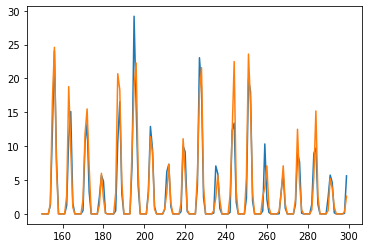

In [ ]:
plt.plot(tResults['Train Predications'][150:300])
plt.plot(tResults['Actuals'][150:300])

In [ ]:
tResults

,Train Predications,Actuals
0,0.000041,0.0
1,0.014522,0.0
2,10.883048,12.0
3,34.031948,34.8
4,35.786896,33.9
...,...,...
2995,24.042788,12.2
2996,21.282963,22.9
2997,7.656821,6.8
2998,0.005341,0.0


In [ ]:
trainPredictions = modelLoad.predict(x).flatten()
tResults = pd.DataFrame(data={'Train Predications':trainPredictions, 'Actuals':y})

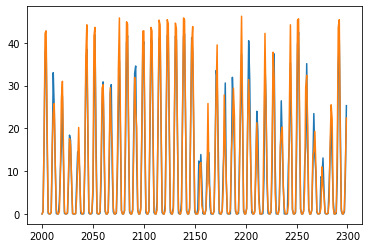

In [ ]:
tResults = tResults.round({'Train Predications': 2})
plt.plot(tResults['Train Predications'][2000:2300])
plt.plot(tResults['Actuals'][2000:2300])

In [ ]:
tResults

,Train Predications,Actuals
0,0.000000,0.0
1,0.010000,0.0
2,10.880000,12.0
3,34.029999,34.8
4,35.790001,33.9
...,...,...
3595,1.780000,1.8
3596,0.700000,0.9
3597,0.020000,0.0
3598,0.000000,0.0


In [ ]:
output = df.copy()


In [ ]:
output.reset_index(inplace=True)
output

,forecastPeriod,temperature,weatherType,uvindex,AO_PV_generation,Day sin,Day cos,Year sin,Year cos
0,2019-09-01 00:00:00,14,7,0,0.0,-8.223106e-12,1.000000e+00,-0.862760,-0.505613
1,2019-09-01 03:00:00,12,2,0,0.0,7.071068e-01,7.071068e-01,-0.863845,-0.503757
2,2019-09-01 06:00:00,12,1,1,13.1,1.000000e+00,1.078645e-11,-0.864927,-0.501898
3,2019-09-01 09:00:00,14,3,3,32.1,7.071068e-01,-7.071068e-01,-0.866004,-0.500037
4,2019-09-01 12:00:00,17,3,5,33.2,1.334979e-11,-1.000000e+00,-0.867077,-0.498174
...,...,...,...,...,...,...,...,...,...
3651,2020-11-30 09:00:00,9,8,1,1.8,7.071068e-01,-7.071068e-01,-0.508255,0.861207
3652,2020-11-30 12:00:00,11,7,1,0.9,3.172823e-12,-1.000000e+00,-0.506402,0.862298
3653,2020-11-30 15:00:00,11,7,1,0.0,-7.071068e-01,-7.071068e-01,-0.504546,0.863385
3654,2020-11-30 18:00:00,10,7,0,0.0,-1.000000e+00,-5.736167e-12,-0.502689,0.864468


In [ ]:
predictions = tResults['Train Predications'].to_list()
output['Predictions'] = pd.Series(predictions)
output

,forecastPeriod,temperature,weatherType,uvindex,AO_PV_generation,Day sin,Day cos,Year sin,Year cos,Predictions
0,2019-09-01 00:00:00,14,7,0,0.0,-8.223106e-12,1.000000e+00,-0.862760,-0.505613,0.000000
1,2019-09-01 03:00:00,12,2,0,0.0,7.071068e-01,7.071068e-01,-0.863845,-0.503757,0.010000
2,2019-09-01 06:00:00,12,1,1,13.1,1.000000e+00,1.078645e-11,-0.864927,-0.501898,10.880000
3,2019-09-01 09:00:00,14,3,3,32.1,7.071068e-01,-7.071068e-01,-0.866004,-0.500037,34.029999
4,2019-09-01 12:00:00,17,3,5,33.2,1.334979e-11,-1.000000e+00,-0.867077,-0.498174,35.790001
...,...,...,...,...,...,...,...,...,...,...
3651,2020-11-30 09:00:00,9,8,1,1.8,7.071068e-01,-7.071068e-01,-0.508255,0.861207,NaN
3652,2020-11-30 12:00:00,11,7,1,0.9,3.172823e-12,-1.000000e+00,-0.506402,0.862298,NaN
3653,2020-11-30 15:00:00,11,7,1,0.0,-7.071068e-01,-7.071068e-01,-0.504546,0.863385,NaN
3654,2020-11-30 18:00:00,10,7,0,0.0,-1.000000e+00,-5.736167e-12,-0.502689,0.864468,NaN


In [ ]:
output.to_csv('solar-predictions')